In [1]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
%matplotlib notebook
from main import *

In [2]:
#Extracting the SS coverages previously saved and extracted from kMC files
ss_COVG_NONLAT = pd.read_csv('SS_Covg_nonLat.csv')
ss_COVG_LAT = pd.read_csv('SS_Covg_Lat.csv')

In [3]:
#Isolating pressures and ss coverages
Prs_non_lat = ss_COVG_NONLAT.iloc[:,0].to_numpy()
Prs_lat = ss_COVG_LAT.iloc[:,0].to_numpy()
ss_covg_non_lat = ss_COVG_NONLAT.iloc[:,1].to_numpy()
ss_covg_lat = ss_COVG_LAT.iloc[:,1].to_numpy()

In [4]:
#Simulation times from each kMC simulation
t0,tf = 0,750.000000000102

In [5]:
%%time
#Performing SS MIKI MKM simulations for non lateral case
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(t0,tf)
MKM.rate_const_correction='None'
MKM_SS_covg_NONLAT = []
Prs = Prs_non_lat
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_NONLAT = np.append(MKM_SS_covg_NONLAT,MKM.get_SS_coverages(print_warning=False)[0])

Mass is conserved. 

CPU times: user 5.1 s, sys: 157 ms, total: 5.25 s
Wall time: 6.34 s


<IPython.core.display.Javascript object>


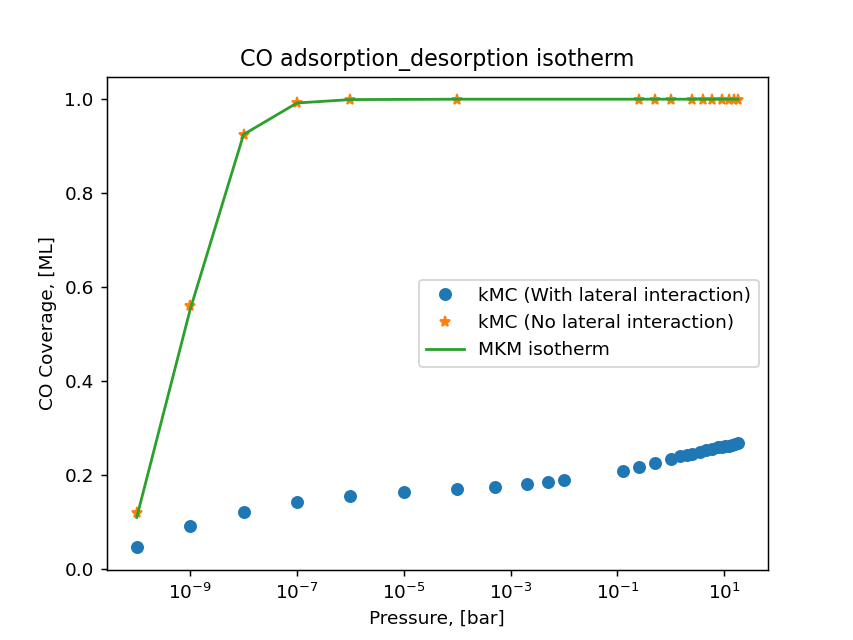

In [6]:
plt.figure()
plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

In [7]:
# For lateral only
##Step 1: Calculating Ki based on isotherm equation
Ki_lateral = []
for i in np.arange(len(Prs_lat)):
    Ki_lateral.append(ss_covg_lat[i]/((1-ss_covg_lat[i]) * Prs_lat[i]))
    
##Step 2: Calculating fi(theta)
Keq = MKM.k[0]/MKM.k[1]
fi_theta = []
for i in np.arange(len(Prs_lat)):
    fi_theta.append(Ki_lateral[i]/Keq)
    
##Therefore need to train ML model (for lateral interactions considered) where x is theta and y is fi_theta
##Step 3: MLM model
print('For Lateral:\n')
print('Pressure, SS_coverage_CO, K_from_isoeqn, f(theta)')
print(np.array([Prs_lat,ss_covg_lat,Ki_lateral,fi_theta]).T)

For Lateral:

Pressure, SS_coverage_CO, K_from_isoeqn, f(theta)
[[1.00000000e-10 4.63296155e-02 4.85803232e+08 3.94275087e-01]
 [1.00000000e-09 9.11109711e-02 1.00244329e+08 8.13577165e-02]
 [1.00000000e-08 1.21996393e-01 1.38947485e+07 1.12768973e-02]
 [1.00000000e-07 1.43216148e-01 1.67155517e+06 1.35662448e-03]
 [1.00000000e-06 1.55425457e-01 1.84028110e+05 1.49356148e-04]
 [1.00000000e-05 1.63325156e-01 1.95207442e+04 1.58429228e-05]
 [1.00000000e-04 1.70388884e-01 2.05384042e+03 1.66688498e-06]
 [5.00000000e-04 1.75406734e-01 4.25438192e+02 3.45283170e-07]
 [2.00000000e-03 1.80016145e-01 1.09768104e+02 8.90871566e-08]
 [5.00000000e-03 1.84291328e-01 4.51855752e+01 3.66723509e-08]
 [1.00000000e-02 1.88856113e-01 2.32826895e+01 1.88960958e-08]
 [1.25000000e-01 2.08986241e-01 2.11360411e+00 1.71538884e-09]
 [2.50000000e-01 2.17408512e-01 1.11122350e+00 9.01862547e-10]
 [5.00000000e-01 2.25479268e-01 5.82242045e-01 4.72544269e-10]
 [1.00000000e+00 2.34419844e-01 3.06198955e-01 2.48509

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sympy import *
from sklearn.utils.random import check_random_state
import graphviz
import time

In [9]:
data = np.array([ss_covg_lat, fi_theta]).T
columns = ['theta', 'f(theta)']
df = pd.DataFrame(data = data, columns = columns)
df.head()

,theta,f(theta)
0,0.046330,0.394275
1,0.091111,0.081358
2,0.121996,0.011277
3,0.143216,0.001357
4,0.155425,0.000149


<IPython.core.display.Javascript object>


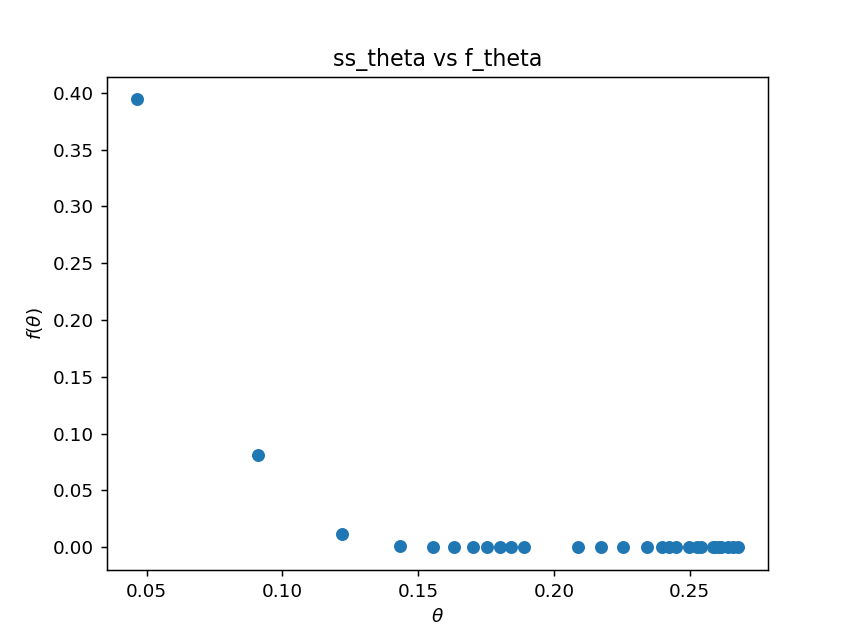

Text(0.5, 0, '$\\theta$')

In [10]:
plt.figure(dpi = 100)
plt.title('ss_theta vs f_theta')
plt.scatter(df['theta'], df['f(theta)'])
plt.ylabel(r'$f(\theta)$')
plt.xlabel(r'$\theta$')

In [11]:
X = df[['theta']]
y = df['f(theta)']
y_true = y
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.30, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19, 1), (9, 1), (19,), (9,))

In [12]:
def ML_model(algorithm="XGBoost", X_train = X_train, Y_train = y_train):
    
    #XGBoost Algorithm
    #https://xgboost.readthedocs.io/en/stable/python/python_api.html
    if algorithm=="XGBoost":  
        import xgboost as xgb

        reg = xgb.XGBRegressor(booster='gbtree',    
                               n_estimators=15000,
                               objective='reg:squarederror',
                               max_depth=20,
                               learning_rate=0.01)
        reg.fit(X_train, Y_train,
                eval_set=[(X_train, Y_train)],
                verbose=False)
    
    #Artificial Neural Network
    #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
    elif algorithm=="ANN":
        from sklearn.neural_network import MLPRegressor
        No_H_nodes_per_layer = 3
        print('Number of Hidden layer nodes per layer : ',No_H_nodes_per_layer)
        No_H_layers = 6
        print('Number of Hidden layers: ',No_H_layers)

        hidden_layers = No_H_nodes_per_layer*np.ones(No_H_layers) 
        hidden_layer_sizes = tuple(tuple(int(item) for item in hidden_layers))
        reg = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                            activation='relu', 
                            solver='adam')
#                            ,random_state=42, 
#                             max_iter=300)

        reg.fit(X_train, Y_train)
    
    #K-Nearest Neighbor
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
    elif algorithm=="KNN":
        from sklearn.neighbors import KNeighborsRegressor

        reg = KNeighborsRegressor(n_neighbors=50, weights='distance',p=1)
        reg.fit(X_train, Y_train)
    
    #RandomForest 
    #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
    elif algorithm=='RandomForest':
        from sklearn.ensemble import RandomForestRegressor
        
        reg = RandomForestRegressor(n_estimators=10000, criterion='squared_error', random_state=24)

        reg.fit(X_train, Y_train)
        
        print('Features:',X_train.columns)
        
        print('\nFeature Importance:\n',reg.feature_importances_) #Shows which features are chosen most when doing splits #gives the most information
        
    elif algorithm=='DecisionTree':
        from sklearn import tree
        reg = tree.DecisionTreeRegressor()#criterion='poisson',max_depth=20,min_samples_leaf=10,min_samples_split=20
        
        reg.fit(X_train, Y_train)
        
        print('Features:',X_train.columns)
        
        print('\nFeature Importance:\n',reg.feature_importances_) #Shows which features are chosen most when doing splits #gives the most information

    return reg

In [13]:
import time
######### OPTIONS: 'XGBoost','ANN','KNN','RandomForest'#########
################################################################
ALGORITHM_NAME = "RandomForest"
################################################################

start_time = time.time()
reg = ML_model(algorithm = 'RandomForest')
end_time = time.time()

elapsed_time = end_time - start_time
print("\nElapsed Model Training Time: \n", elapsed_time, "seconds \n", elapsed_time/60, "minutes")

Features: Index(['theta'], dtype='object')

Feature Importance:
 [1.]

Elapsed Model Training Time: 
 14.701825857162476 seconds 
 0.24503043095270793 minutes


In [14]:
Y_output = reg.predict(X_test)

In [15]:
from math import sqrt
from sklearn.metrics import mean_squared_error
#Calculating the root mean squared of the test set
print('Root Mean Squared Error:\n',sqrt(mean_squared_error(Y_output, y_test)))

Root Mean Squared Error:
 0.11309607489427068


In [16]:
#Simulation times from each kMC simulation
t0,tf = 0,750.000000000102

In [17]:
%%time
#Performing SS MIKI MKM simulations for lateral case
from main import *
MKMCD = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKMCD.Thermo_Constraint = 'OFF'
MKMCD.set_limits_of_integration(t0,tf)
colmn = len(MKMCD.Stoich.iloc[0,1:]) - len(MKMCD.P) #Number of columns (i.e rate coefficients = no. of surface species being investigated)
row = len(MKMCD.k) #number of rows = number of rate constants (i.e reaction steps)
MKM_SS_covg_LAT = []
Prs = Prs_lat #Lateral pressures## TO BE PREDICTED###########################################################
for i in np.arange(len(Prs)):
    MKMCD.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_LAT = np.append(MKM_SS_covg_LAT,MKMCD.get_SS_coverages(print_warning=True)[0])    

Mass is conserved. 

Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
CPU times: user 9.37 s, sys: 421 ms, total: 9.79 s
Wall time: 13.4 s


In [18]:
##Step 4-> Getting predicted _f(theta)
f_theta_pred = reg.predict(np.array([MKM_SS_covg_LAT]).T)
# f_theta_pred = np.exp(0.03483852*(MKM_SS_covg_LAT**3))
# f_theta_pred = np.exp(-MKM_SS_covg_LAT)-np.exp(MKM_SS_covg_LAT)

##Step 5-> Recalculating Ki_lateral from Keq : f = Ki/Keq
Ki_lateral_pred = []
for i in np.arange(len(Prs)):
    Ki_lateral_pred.append(f_theta_pred[i]*Keq)

##Step6-> Calculating predicted theta
ML_theta_pred = []
for i in np.arange(len(Prs)):
    ML_theta_pred.append((Ki_lateral_pred[i]*Prs[i])/(1+(Ki_lateral_pred[i]*Prs[i])))

/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


<IPython.core.display.Javascript object>


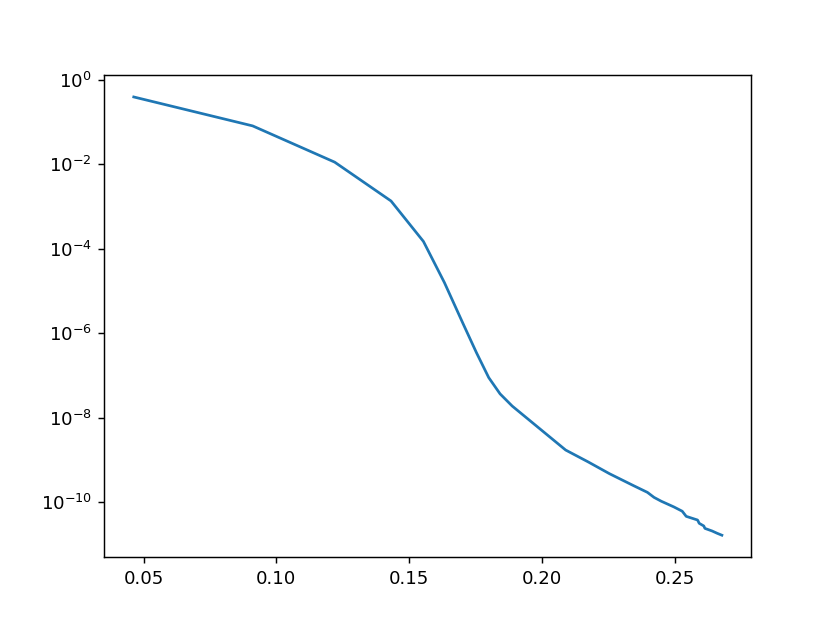

In [28]:
plt.figure()
plt.semilogy(df['theta'], df['f(theta)'])
plt.show()

<IPython.core.display.Javascript object>


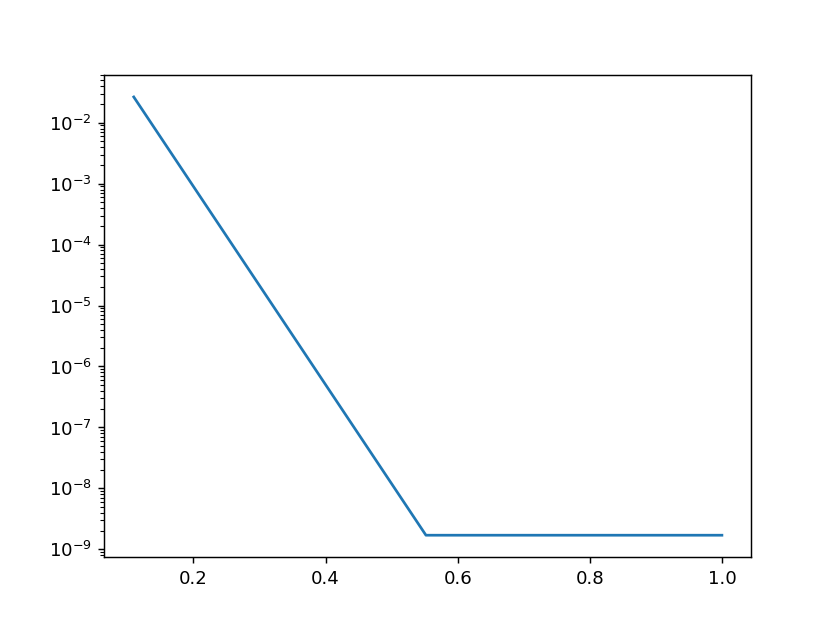

In [27]:
plt.figure()
plt.semilogy(MKM_SS_covg_LAT,f_theta_pred)
plt.show()

In [19]:
print('Root Mean Squared Error:\n',sqrt(mean_squared_error(y, f_theta_pred)))
print('Root Mean Squared Error:\n',sqrt(mean_squared_error(ss_covg_lat, ML_theta_pred)))

Root Mean Squared Error:
 0.071224854823561371095965989055923941416330683880809
Root Mean Squared Error:
 0.46908341790851977640243446534473344716860508855592


<IPython.core.display.Javascript object>


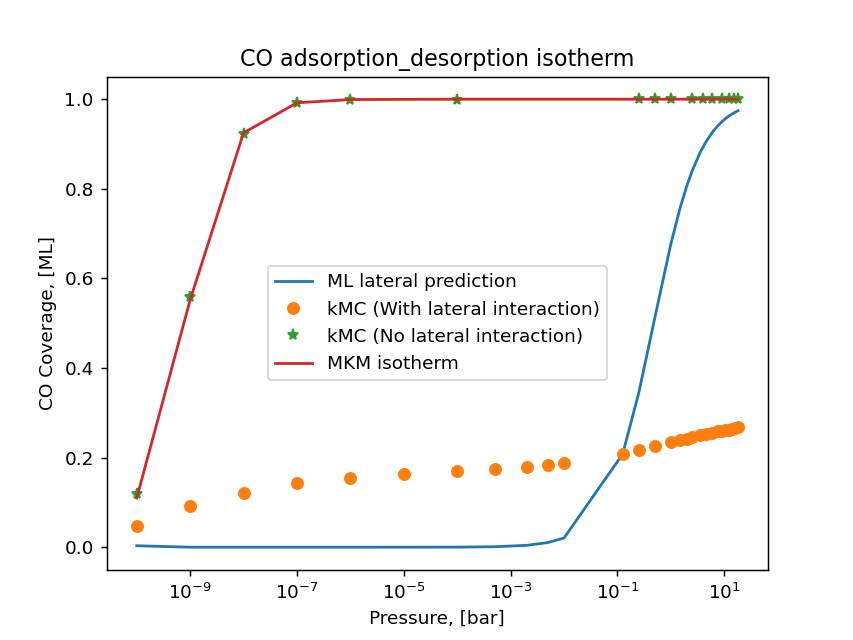

In [20]:
plt.figure()
plt.semilogx(Prs,ML_theta_pred,'-',label='ML lateral prediction')
plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

<IPython.core.display.Javascript object>


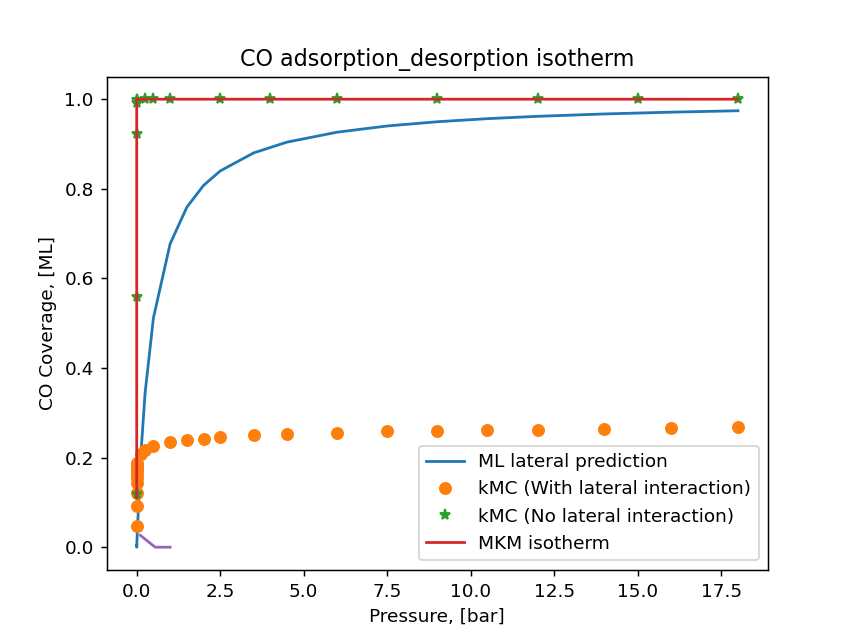

In [21]:
plt.figure()
plt.plot(Prs,ML_theta_pred,'-',label='ML lateral prediction')
plt.plot(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.plot(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.plot(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()


Elapsed Model Training Time: 
 25.70861792564392 seconds 
 0.42847696542739866 minutes
Mass is conserved. 

Root Mean Squared Error:
 0.68334791186784754268817094950083991305246721369601


<IPython.core.display.Javascript object>


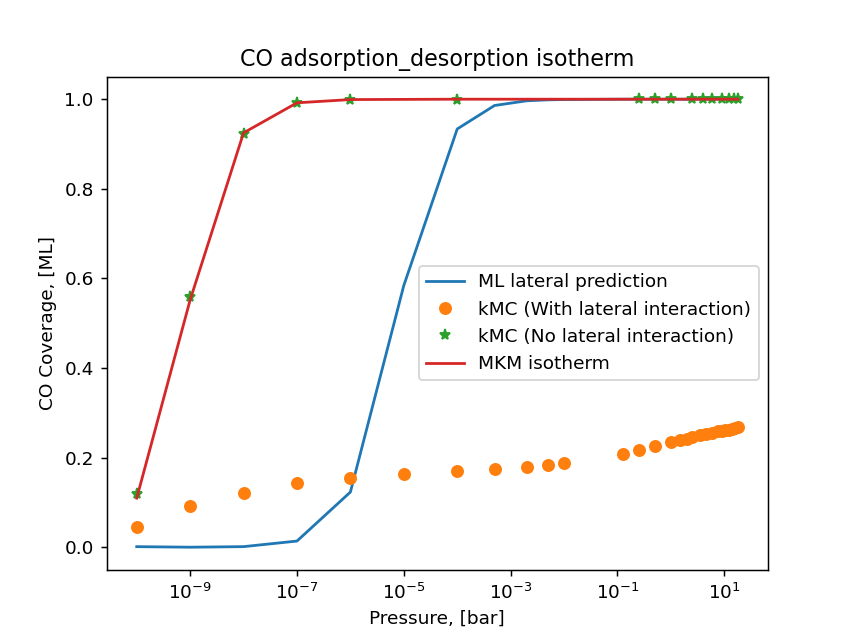

<IPython.core.display.Javascript object>


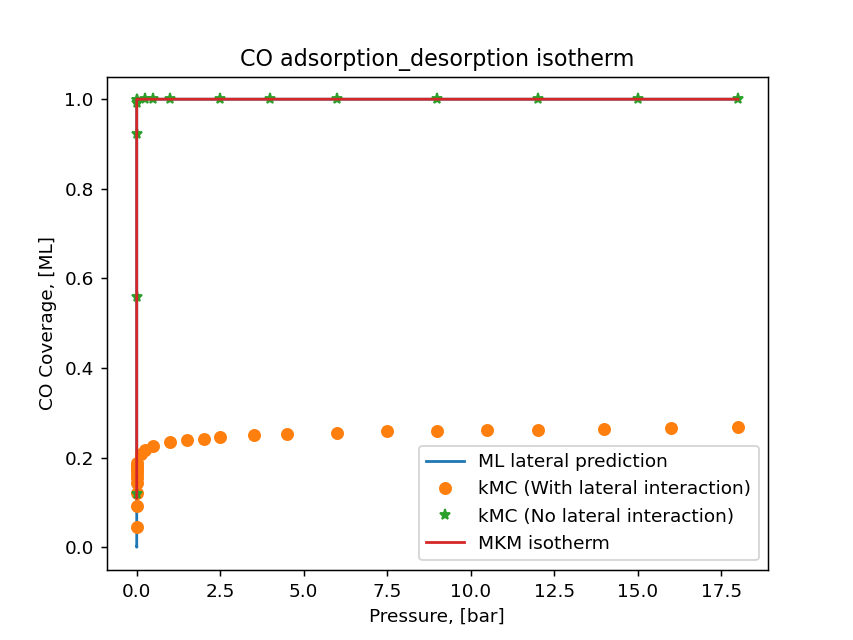

Number of Hidden layer nodes per layer :  3
Number of Hidden layers:  6

Elapsed Model Training Time: 
 0.12285184860229492 seconds 
 0.002047530810038249 minutes
Mass is conserved. 

Root Mean Squared Error:
 0.71616178114284107354233992122015465474448286507428


/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


<IPython.core.display.Javascript object>


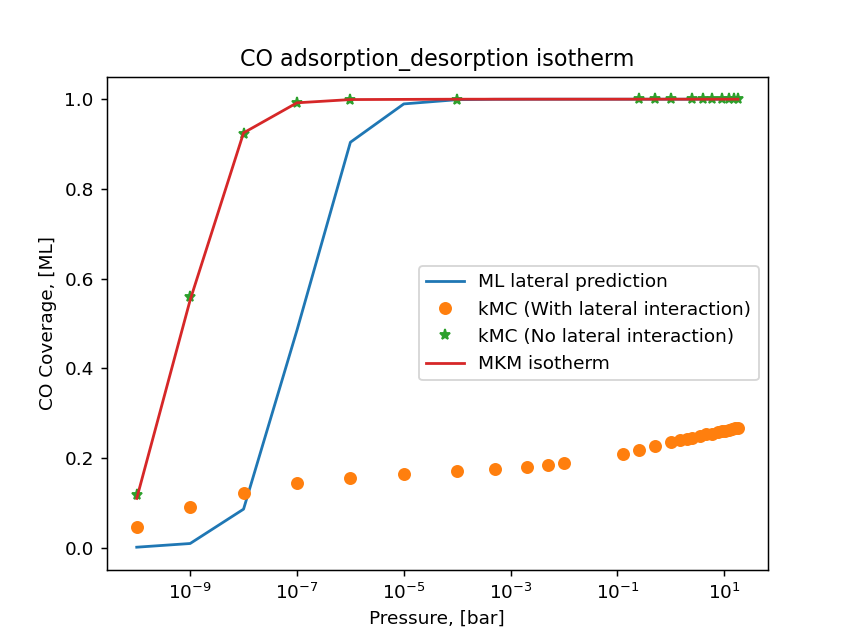

<IPython.core.display.Javascript object>


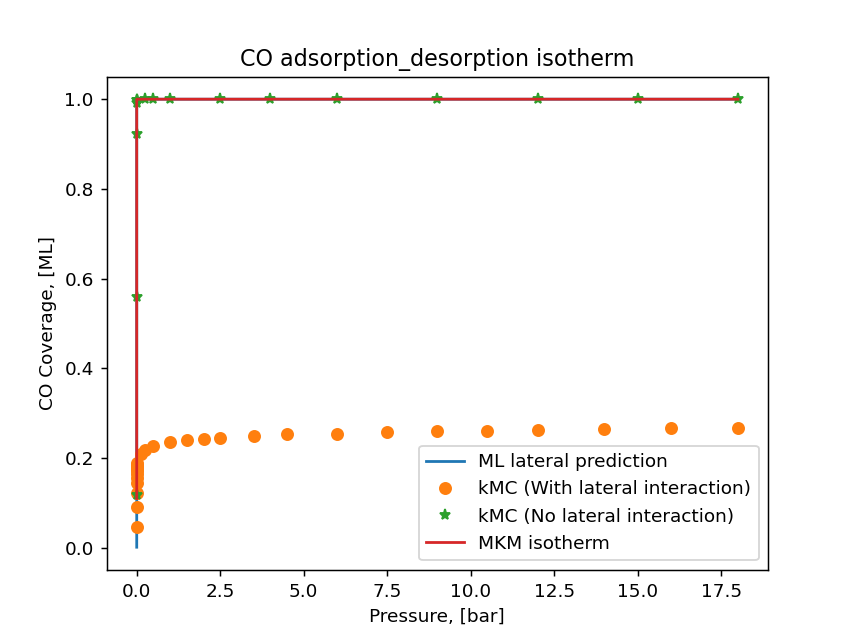

Features: Index(['theta'], dtype='object')

Feature Importance:
 [1.]

Elapsed Model Training Time: 
 15.20148491859436 seconds 
 0.25335808197657267 minutes
Mass is conserved. 



/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Root Mean Squared Error:
 0.46908341790851977640243446534473344716860508855592


<IPython.core.display.Javascript object>


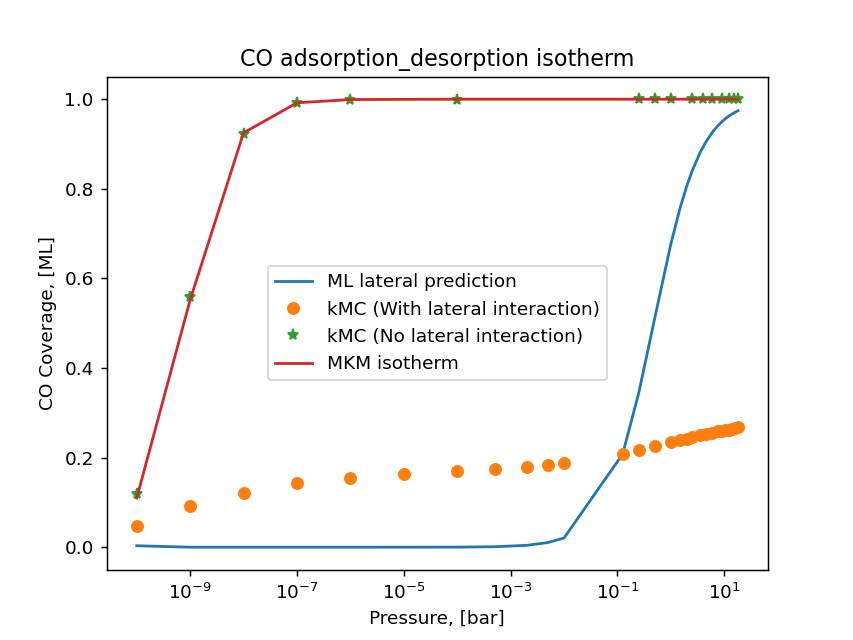

<IPython.core.display.Javascript object>


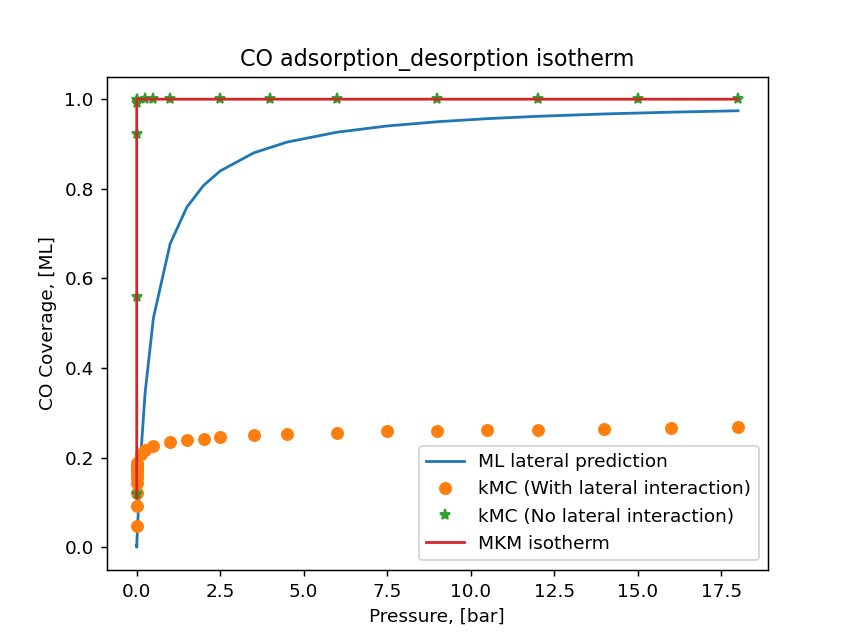

In [22]:
import time
######### OPTIONS: 'XGBoost','ANN','KNN','RandomForest'#########
################################################################
ALGORITHM_NAME = "RandomForest"
################################################################
alglist = ['XGBoost','ANN','RandomForest']
for i in alglist:
    start_time = time.time()
    reg = ML_model(algorithm = i)
    end_time = time.time()

    elapsed_time = end_time - start_time
    print("\nElapsed Model Training Time: \n", elapsed_time, "seconds \n", elapsed_time/60, "minutes")
    
    
    #Performing SS MIKI MKM simulations for lateral case
    from main import *
    MKMCD = MKModel('Atomic.csv','Stoich.csv','Param.csv')
    MKMCD.Thermo_Constraint = 'OFF'
    MKMCD.set_limits_of_integration(t0,tf)
    colmn = len(MKMCD.Stoich.iloc[0,1:]) - len(MKMCD.P) #Number of columns (i.e rate coefficients = no. of surface species being investigated)
    row = len(MKMCD.k) #number of rows = number of rate constants (i.e reaction steps)
    MKM_SS_covg_LAT = []
    Prs = Prs_lat #Lateral pressures## TO BE PREDICTED###########################################################
    for i in np.arange(len(Prs)):
        MKMCD.set_rxnconditions(Pr=[Prs[i]])
        MKM_SS_covg_LAT = np.append(MKM_SS_covg_LAT,MKMCD.get_SS_coverages(print_warning=False)[0])    
    
    ##Step 4-> Getting predicted _f(theta)
    f_theta_pred = reg.predict(np.array([MKM_SS_covg_LAT]).T)

    ##Step 5-> Recalculating Ki_lateral from Keq : f = Ki/Keq
    Ki_lateral_pred = []
    for i in np.arange(len(Prs)):
        Ki_lateral_pred.append(f_theta_pred[i]*Keq)

    ##Step6-> Calculating predicted theta
    ML_theta_pred = []
    for i in np.arange(len(Prs)):
        ML_theta_pred.append((Ki_lateral_pred[i]*Prs[i])/(1+(Ki_lateral_pred[i]*Prs[i])))
        
    print('Root Mean Squared Error:\n',sqrt(mean_squared_error(ss_covg_lat, ML_theta_pred)))
    
    plt.figure()
    plt.semilogx(Prs,ML_theta_pred,'-',label='ML lateral prediction')
    plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
    plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
    plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
    # plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
    plt.legend()
    plt.title('CO adsorption_desorption isotherm')
    plt.xlabel('Pressure, [bar]')
    plt.ylabel('CO Coverage, [ML]')
    plt.show()
    
    
    plt.figure()
    plt.plot(Prs,ML_theta_pred,'-',label='ML lateral prediction')
    plt.plot(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
    plt.plot(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
    plt.plot(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
    # plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
    plt.legend()
    plt.title('CO adsorption_desorption isotherm')
    plt.xlabel('Pressure, [bar]')
    plt.ylabel('CO Coverage, [ML]')
    plt.show()

In [23]:
##Step4: Return model based on 